In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [86]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [87]:
df=pd.read_csv("/content/BNB Historical Data.csv")

In [88]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,27-09-2024,606.90,596.40,614.22,596.10,371.70K,1.76%
1,26-09-2024,596.40,587.53,608.68,581.03,350.53K,1.51%
2,25-09-2024,587.53,605.91,608.00,584.43,233.05K,-3.03%
3,24-09-2024,605.91,604.70,613.30,599.23,273.45K,0.20%
4,23-09-2024,604.70,588.61,615.70,584.02,395.30K,2.74%


In [89]:
df.drop(columns=['Open','High','Low','Vol.','Change %'],inplace=True)
df.head()

,Date,Price
0,27-09-2024,606.90
1,26-09-2024,596.40
2,25-09-2024,587.53
3,24-09-2024,605.91
4,23-09-2024,604.70


In [90]:
df['Price'] = df['Price'].iloc[::-1].values

In [161]:
# Limit the DataFrame to the last 100 rows
df = df.tail(2000)

# Display the number of rows and columns after limiting
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")


Number of rows: 1000
Number of columns: 2


In [162]:
date = pd.date_range(start='2020-01-01', periods=min(len(df), 2000), freq='D')

In [163]:
df['Year']=date
df.drop('Date',axis=1,inplace=True)
df=df.set_index('Year')
df.head()

KeyError: "['Date'] not found in axis"

In [164]:
df.index = pd.to_datetime(df.index)

# Convert 'Price' column to float after removing commas
df['Price'] = df['Price'].replace(',', '', regex=True).astype(float)

# Verify the data types after conversion
print(df.dtypes)

Price           float64
Year     datetime64[ns]
dtype: object


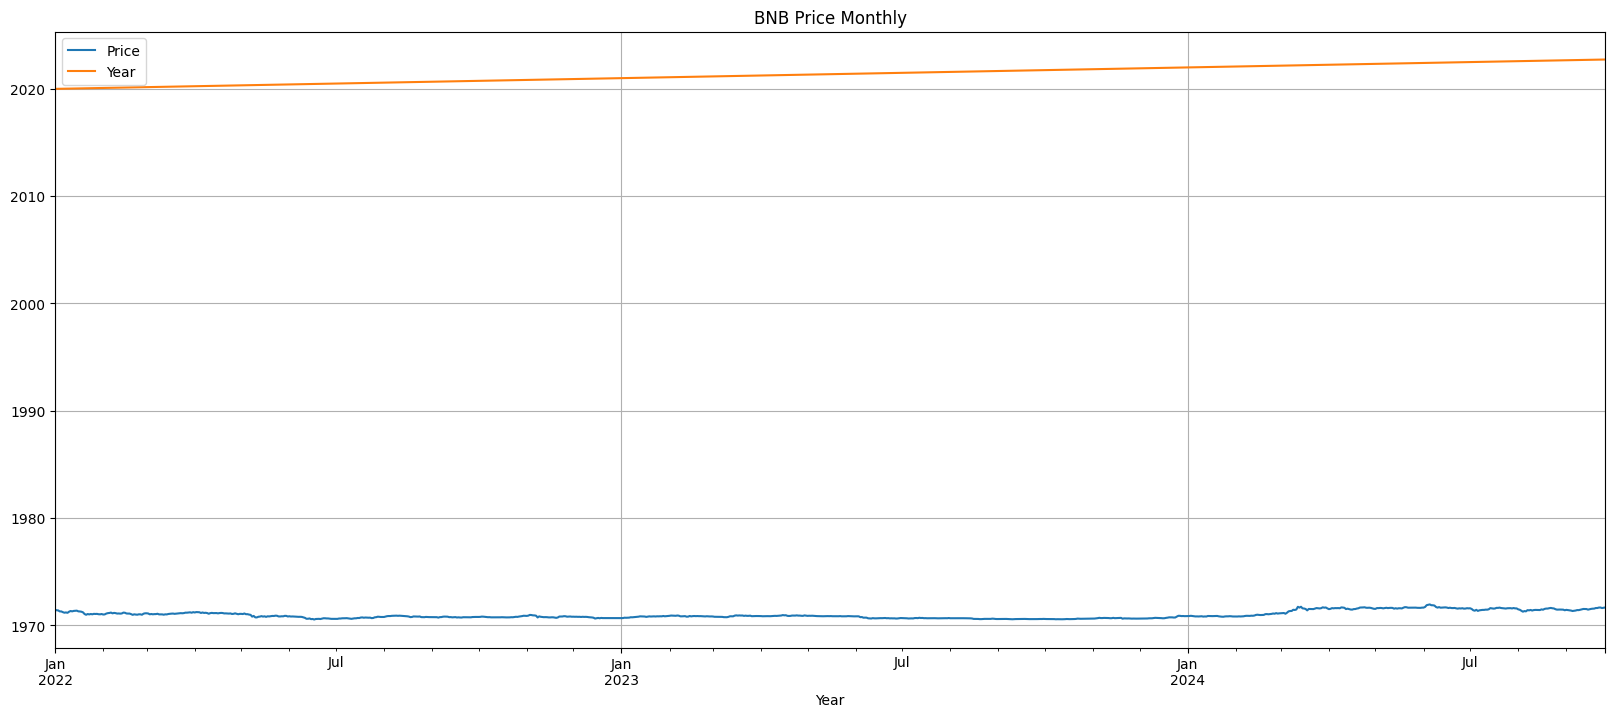

In [165]:
df.plot(figsize=(20,8))
plt.title("BNB Price Monthly")
plt.grid()

In [166]:
df.describe()

,Price,Year
count,1000.000000,1000
mean,353.902620,2021-05-14 12:00:00
min,197.090000,2020-01-01 00:00:00
25%,255.997500,2020-09-06 18:00:00
50%,308.600000,2021-05-14 12:00:00
75%,417.130000,2022-01-19 06:00:00
max,711.160000,2022-09-26 00:00:00
std,124.899809,NaN


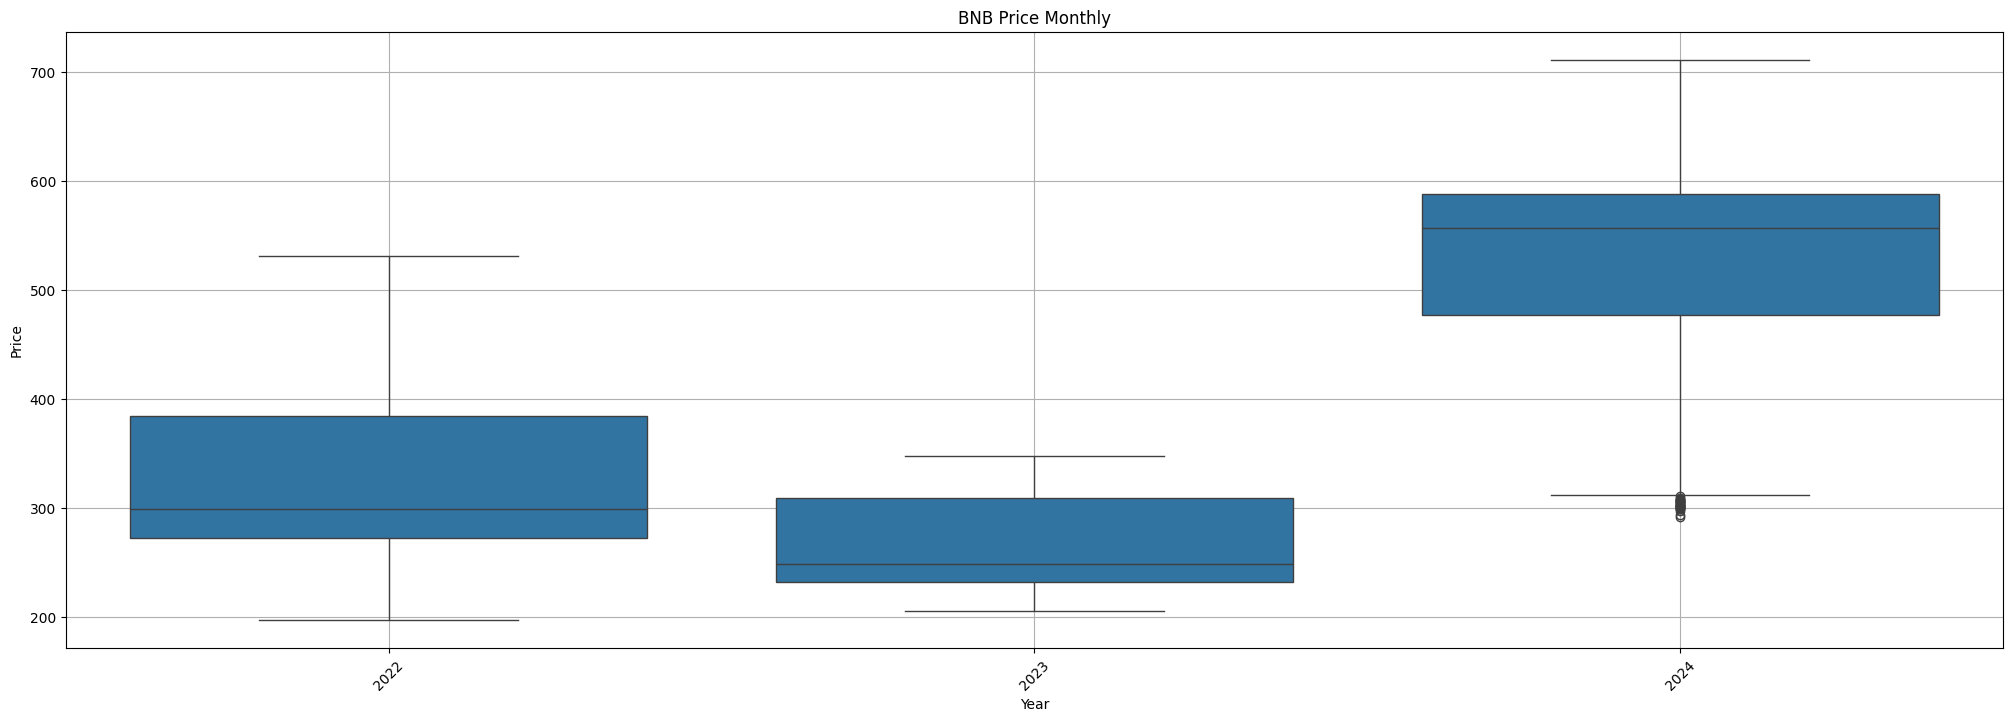

In [167]:
_ , ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.year , y=df.values[:,0] , ax=ax)
plt.title("BNB Price Monthly")
plt.xlabel(f"Year")
plt.ylabel(f"Price")
plt.xticks(rotation=45)
plt.grid()

Text(0.5, 1.0, 'BNB Price Monthly')

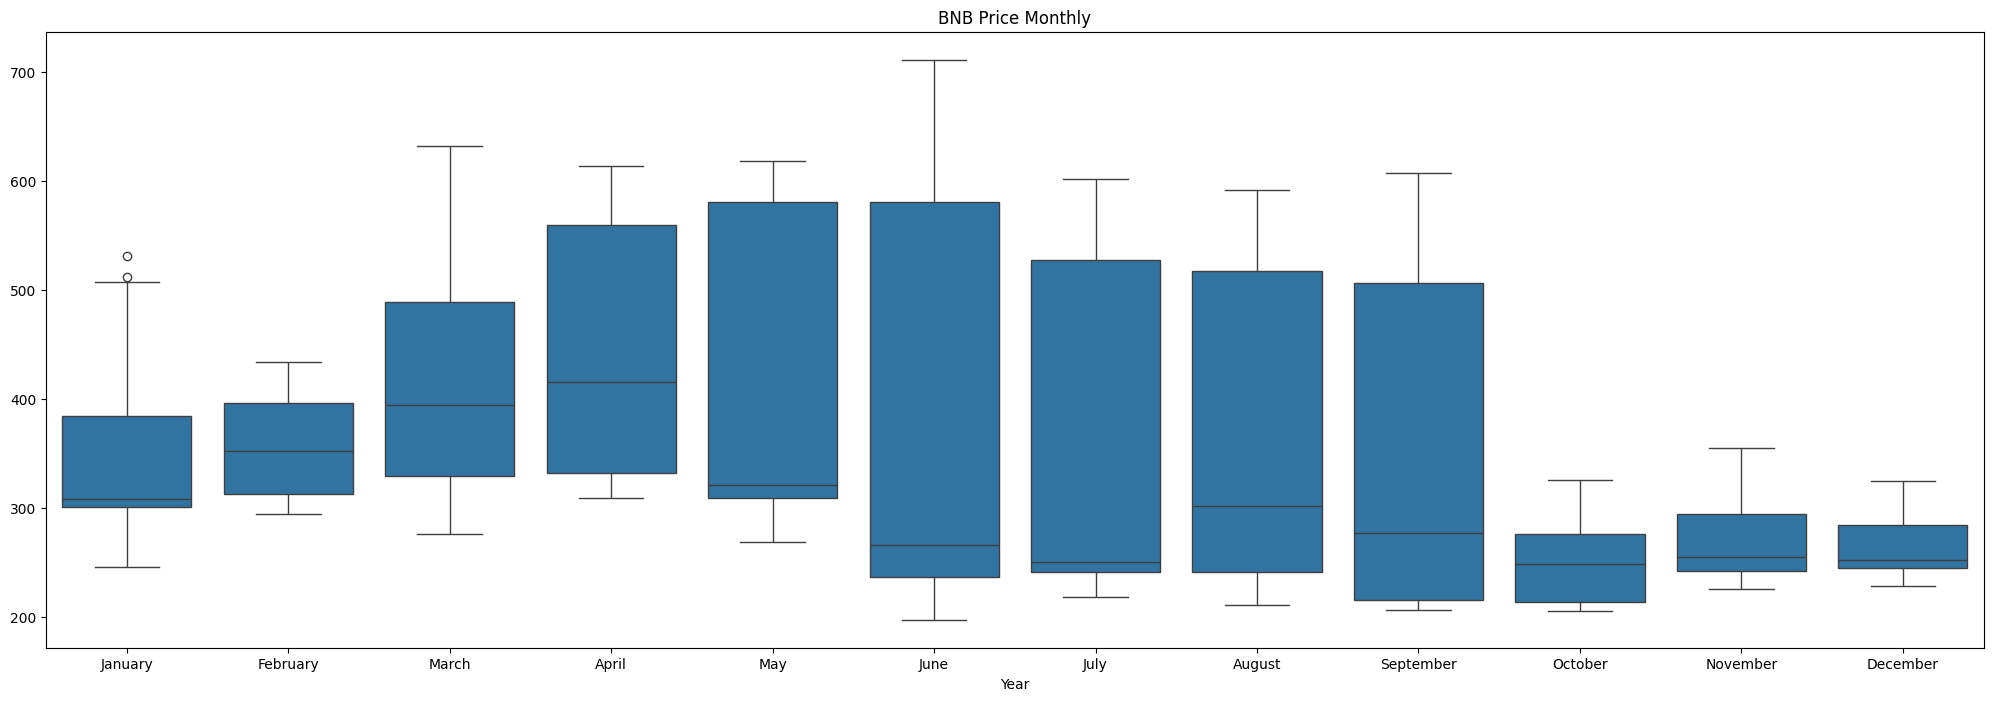

In [168]:
_ , ax = plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.month_name() , y = df.values[:,0], ax=ax)
plt.title("BNB Price Monthly")

In [169]:
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price' : 'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price' : 'Std'}), left_index=True, right_index=True)
df_1['Cov_pct'] = ((df_1['Std']/df_1['Mean'])*100 ).round(2)

In [170]:
df_1.head()

,Mean,Year_x,Std,Year_y,Cov_pct
Year,,,,,
2022,323.508384,2020-07-01 00:00:00.000000000,70.801492,105 days 12:15:21.280456948,21.89
2023,266.669863,2021-07-01 00:00:00.000000256,42.007979,105 days 12:15:21.280456948,15.75
2024,512.916889,2022-05-14 12:00:00.000000000,108.651270,78 days 02:04:32.779970880,21.18


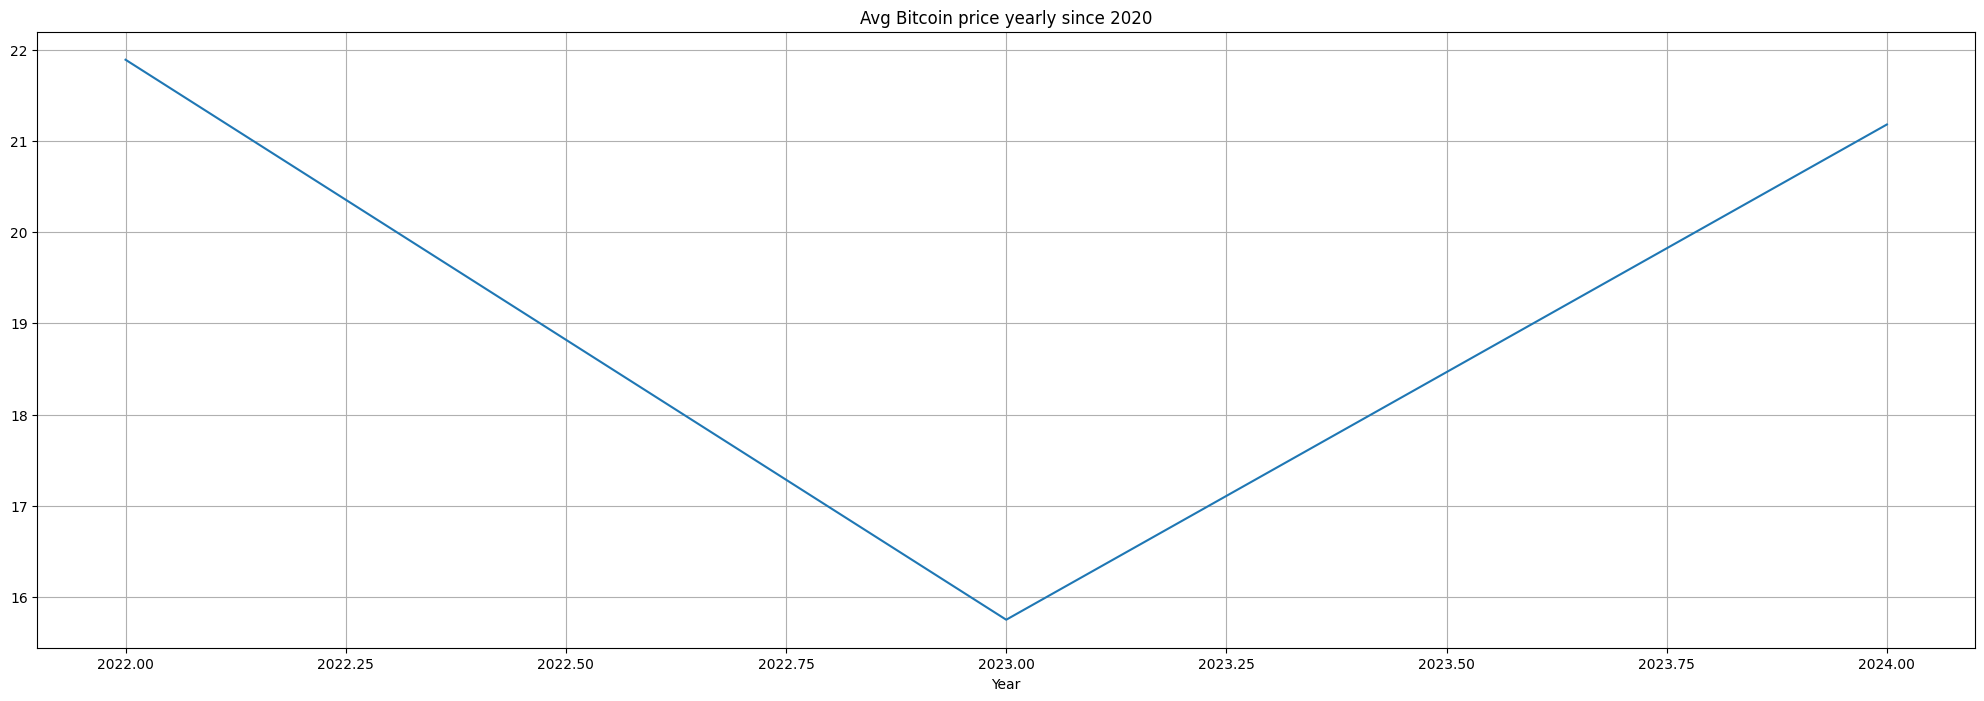

In [171]:
fig , ax = plt.subplots(figsize=(25,8))
df_1['Cov_pct'].plot()
plt.title("Avg Bitcoin price yearly since 2020")
plt.grid()

In [172]:
train = df[df.index.year <= 2023]
test = df[df.index.year > 2023]

In [173]:
print(train.shape)
print(test.shape)

(730, 2)
(270, 2)


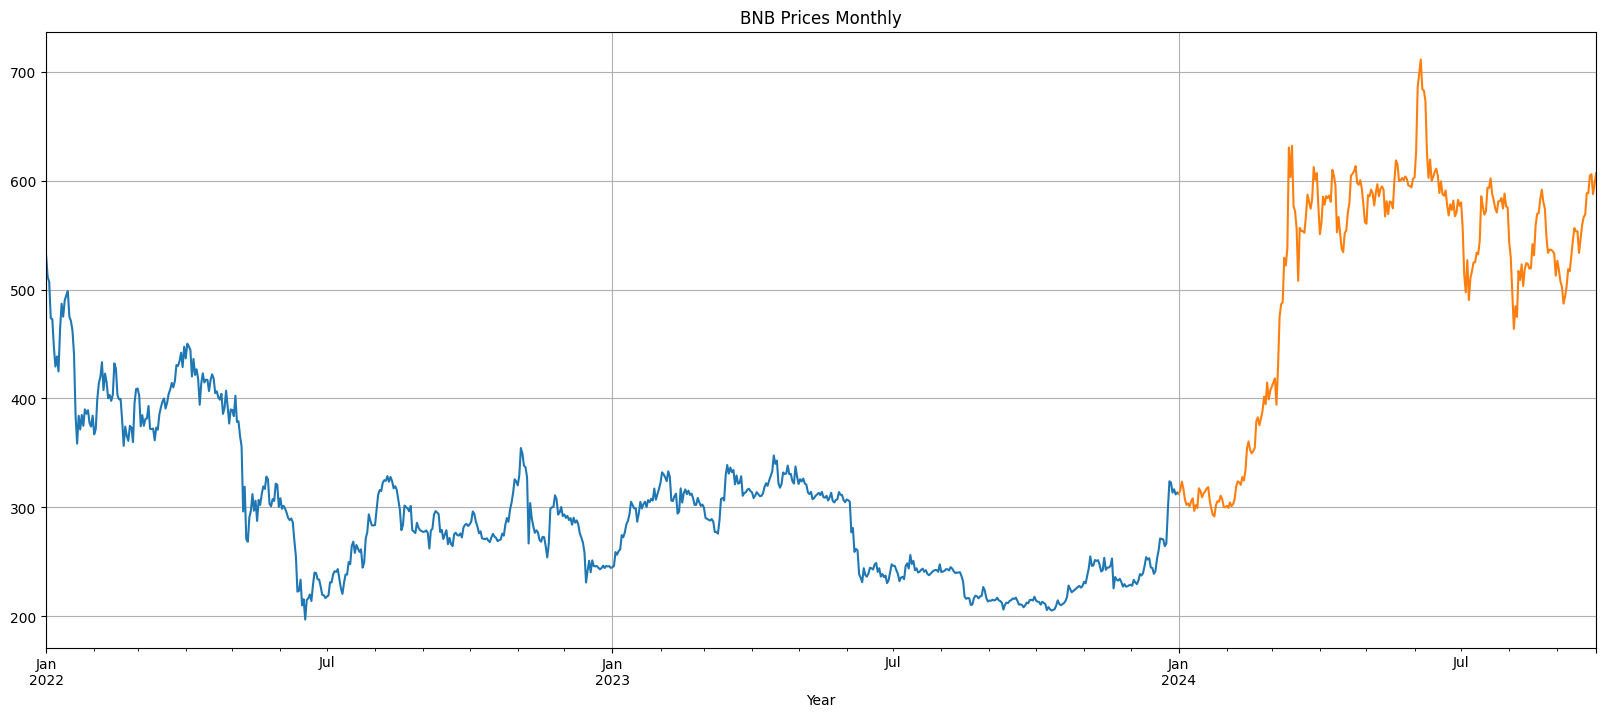

In [174]:
train['Price'].plot(figsize=(20,8))
test['Price'].plot(figsize=(20,8))
plt.title("BNB Prices Monthly")
plt.grid()

In [175]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+1 for i in range(len(test))]
len(train_time), len(test_time)

(730, 270)

In [176]:
Naive_train = train.copy()
Naive_test = test.copy()

In [177]:
LR_train = train.copy()
LR_test = test.copy()

In [178]:
Naive_train['time'] = train_time
Naive_test['time'] = test_time

In [179]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [180]:
Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

,naive
Year,
2024-01-01,313.51
2024-01-02,313.51
2024-01-03,313.51
2024-01-04,313.51
2024-01-05,313.51


In [181]:
lr = LinearRegression()
lr.fit(LR_train[['time']], LR_train['Price'].values)

LinearRegression()

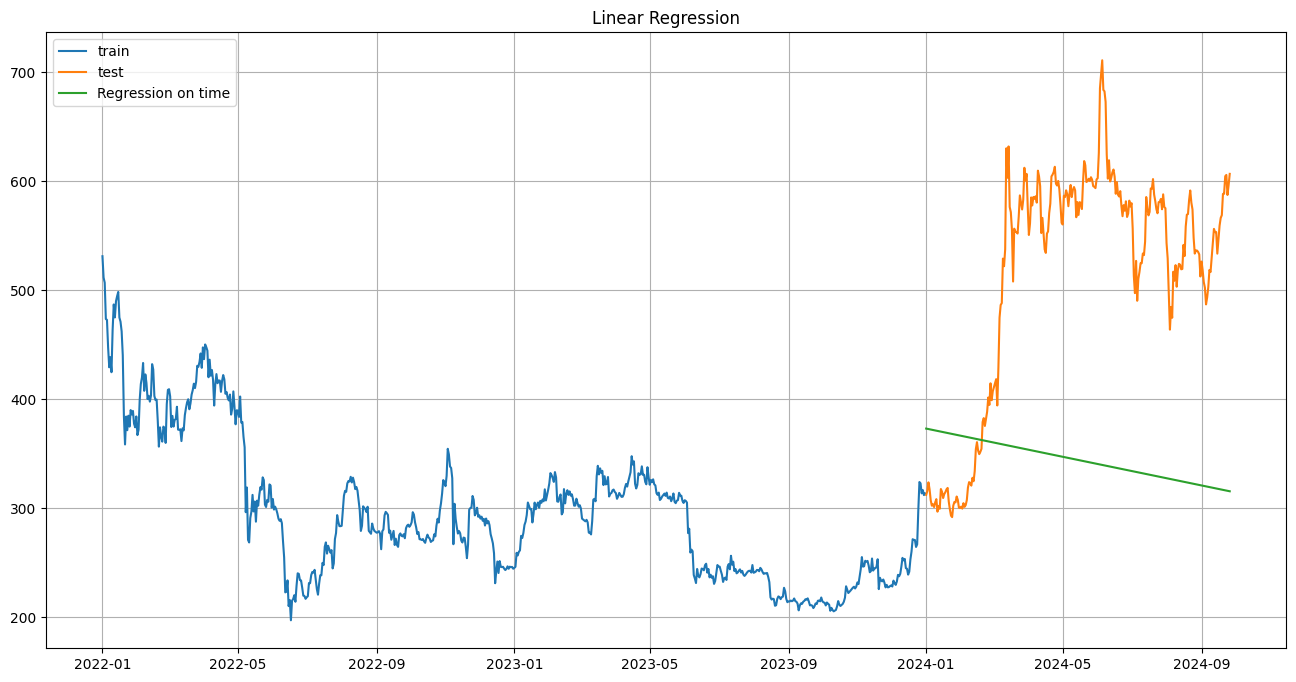

In [182]:
test_predictions_model = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model
plt.figure(figsize=(16,8))
plt.plot(train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(LR_test['forecast'], label='Regression on time')
plt.title('Linear Regression')
plt.legend(loc='best')
plt.grid()
plt.show()

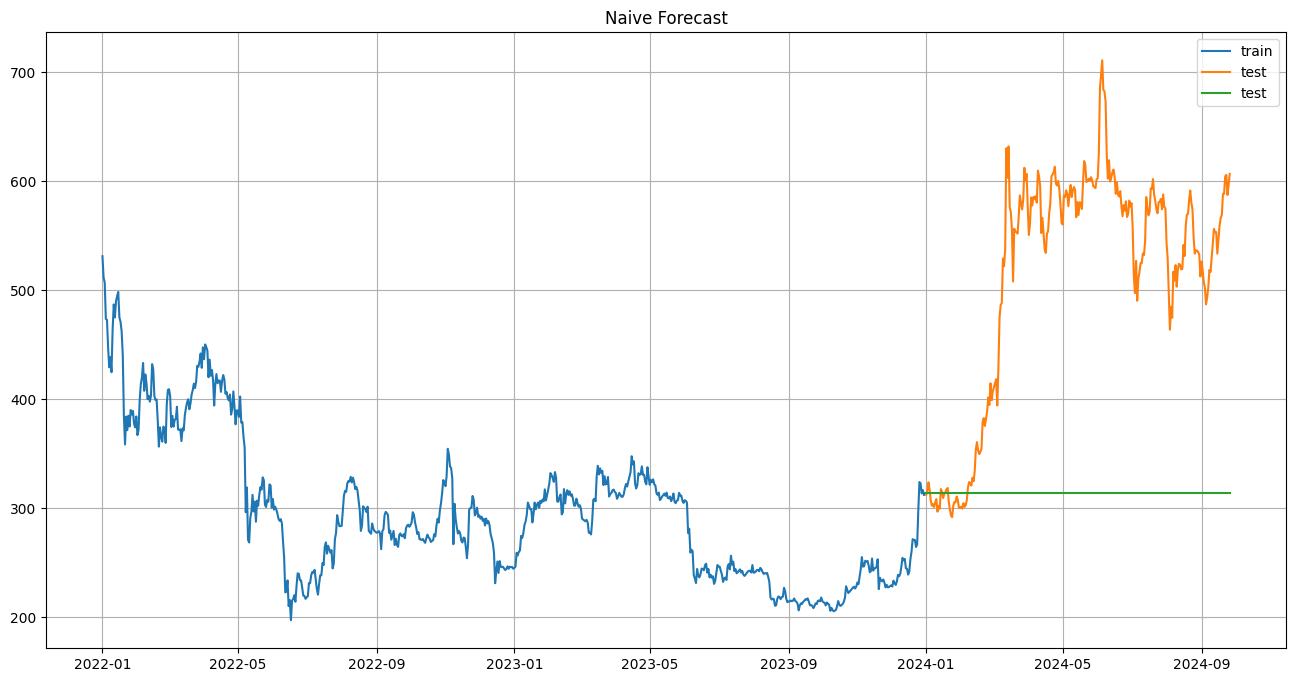

In [183]:
plt.figure(figsize=(16,8))
plt.plot(Naive_train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(Naive_test['naive'],label='test')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.grid()
plt.show()

In [184]:
def mape(actual,pred):
  return round((np.mean(abs(actual - pred)/actual))*100 , 2)

In [185]:
mape_model_test = mape(test['Price'].values,test_predictions_model)
print("MAPE is %3.3f"%(mape_model_test),"%")

MAPE is 34.480 %


In [186]:
results = pd.DataFrame({'Test MAPE (%)': [mape_model_test]}, index=["Regression"])

In [187]:
results

,Test MAPE (%)
Regression,34.48


In [188]:
mape_model_test_2 = mape(test['Price'].values,Naive_test['naive'].values)
print("For Naive Forecast on Test data the MAPE is %3.3f"%(mape_model_test_2),"%")

For Naive Forecast on Test data the MAPE is 35.840 %


In [189]:
results_2 = pd.DataFrame({'Test MAPE (%)': [mape_model_test_2]}, index=["Naive Model"])
result_final = pd.concat( [results,results_2])
result_final

,Test MAPE (%)
Regression,34.48
Naive Model,35.84


In [190]:
final_model = ExponentialSmoothing(df['Price'],trend='additive',seasonal='additive',seasonal_periods=12).fit(smoothing_level=0.4,smoothing_trend=0.3,smoothing_seasonal=0.6)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [191]:
# Ensure the forecasting period doesn't extend too far into the future
forecast_horizon = min(len(test), 30)  # Change 100 to a reasonable number if needed

# Perform the forecast
forecast = final_model.forecast(forecast_horizon)

# Compute the MAPE for the test period, ensuring it matches the forecast horizon
mape_final_model = mape(test['Price'].values[:forecast_horizon], forecast)
print("For Final Model on Test data the MAPE is %3.3f" % mape_final_model, "%")


For Final Model on Test data the MAPE is 52.520 %


In [192]:
# Limit the forecast horizon to prevent the out-of-bounds error
forecast_horizon = min(len(df), 20)  # Adjust 100 to a smaller number if needed

# Perform the forecast
prediction = final_model.forecast(forecast_horizon)


In [193]:
pred_df = pd.DataFrame({'lower_CI':prediction - 1.96*np.std(final_model.resid,ddof=1) , 'prediction':prediction , 'upper_CI':prediction + 1.96*np.std(final_model.resid,ddof=1)})

Text(0.5, 1.0, 'Final Model')

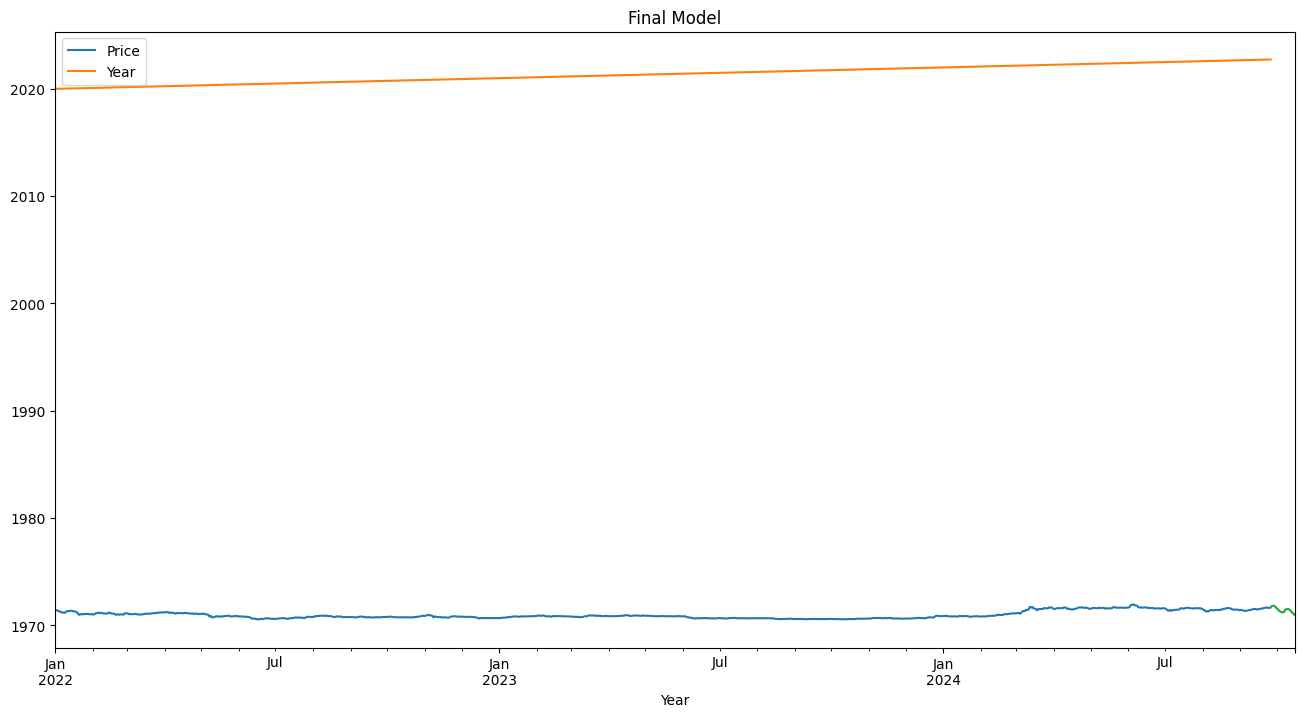

In [194]:
axis = df.plot(label = 'Actual',figsize=(16,8))
pred_df['prediction'].plot(ax=axis,label='Predicted')
plt.title('Final Model')

In [195]:
import pickle
from sklearn.linear_model import LinearRegression

# Save the model
with open('bnb_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)
print("Model saved successfully as 'bnb_model.pkl'.")

# Load the model
with open('bnb_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")


Model saved successfully as 'bnb_model.pkl'.
Model loaded successfully.
